In [163]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux

In [152]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, [1.0, 0.0], [0.0, 1.0])
    return x, y
end

function regime_number(Y, rg=1)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

regime_number (generic function with 2 methods)

### Data loading & processing

In [153]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/test_a3_ev5_2.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end]
nd = length(pdfs) ÷ 2

500

In [154]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])

VelocitySpace1D{Float64,Int64,Vector{Float64},Vector{Float64}}
domain: (-5.0,5.0)
resolution: 100
ghost: 0


In [155]:
dist = Uniform(0.0001, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.000001, 1.0)
kns = rand(dist, nd);

In [156]:
X = zeros(7, nd)
Y = zeros(2, nd)
for i = 1:nd
    #fL = pdfs[i]; fR = pdfs[nd*2-i]
    fL = pop!(pdfs); fR = pop!(pdfs) # shuffle
    wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
    #@show wL, wR
    w = @. (wL + wR) / 2
    sw = @. (wR - wL) / dxs[i]
    f = @. (fL + fR) / 2
    
    X[:, i], Y[:, i] = regime_data(w, sw, f, vs.u, 0, kns[i])
end

In [157]:
regime_number(Y)

NS regime: 107 of 500


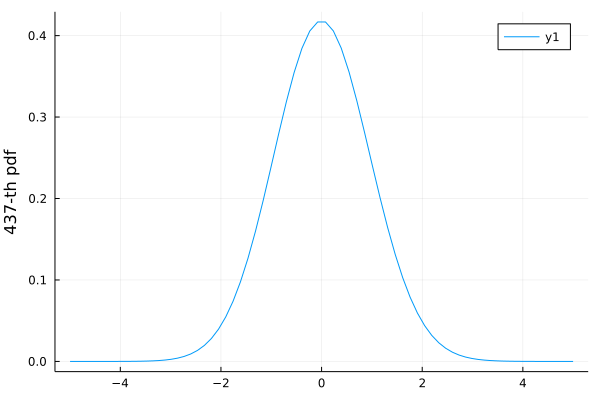

In [158]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Test

In [164]:
@load "../nn.jld2" nn

1-element Vector{Symbol}:
 :nn

In [165]:
nn(randn(7))

2-element Vector{Float64}:
 -0.25423129214294216
  1.2542286868047423